<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson5_BP-FNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behler-Parrinello Fitting Neural Network with Machine Learning Potential (BP-FNN MLP) Models for the Claisen Rearrangement

For this tutorial, we will be combining the Fitting Neural Network (FNN) from Lesson 1 and the Behler-Parrinello Neural Network (BPNN) from Lesson 3 to train a $\Delta$ Machine Learning Potential ($\Delta$MLP) model to reproduce the energy and forces for the claisen rearrangement reaction. With a BP-FNN, we can utilize the symmetry functions from the BPNN model for feature extraction and use the FNN for training. The goal of this model is to train with data that is from the semiempirical (PM3) and DFT (B3LYP) levels of theory. The BP-FNN will be used to correct the semiempirical values to obtain DFT level accuracy, which is what makes it a $\Delta$MLP model.

### Defining the Reaction Coordinate and System Size

The reaction coordinate is $d_1 -d_2$ with 21 windows.

Total of 2100 frames (1 ps/window, frames are saved every 1 fs.)

<img src='https://raw.githubusercontent.com/cc-ats/mlp_class/main/Claisen_Rearrangement/img/pent-4-enal.png' width=200px>



In [ ]:
from IPython.display import HTML

HTML(f"""<video src="https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/img/claisen.mp4" width=300 controls/>""")

<video src='https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/img/claisen.mp4'>




## Importing PyTorch Lightning and Libraries
We will first install PyTorch Lightning and import libraries needed to train our machine learning models.

In [ ]:
%%capture
!pip install pytorch-lightning > /dev/null
import math
import numpy as np
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

## Importing data from GitHub (mlp_tutorial)
We will now import our semiempirical and DFT calculation data.

Files from GitHub:
- **qm_coord.npy** (2100, 14, 3)
- **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
- PM3
- **energy_sqm.npy** (2100,)
- **qm_grad_sqm.npy** (2100, 14, 3)

- B3LYP/6-31+G*
- **energy.npy**  (2100,)
- **qm_grad.npy** (2100, 14, 3)

## Defining the Dense Neural Network

The Dense class contains functions to describe a densely connected neural network.


In [ ]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input

class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)

        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )

## Creating the BP Symmetry Functions

We will define the BP and ANI symmetry functions to ensure that our ML predictions are invariant to translations, rotations, and permutations.


In [ ]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij


def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = (torch.cos(dij / Rcr * math.pi) + 1) * 0.5
    g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=1) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=1))**2) * fij.unsqueeze(dim=-1), dim=2)
    return g2


def symmetry_function_g3(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    f23 = (torch.cos(d23 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)

    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)
    return g3


def symmetry_function_g3ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=1))

    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + cosine)**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=1))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    return g3

## Creating the Feature Classes for BP and ANI

### Defining the BP Feature Class

Now we will create the feature class, which takes input information and uses functions to extract characteristics unique to the input called features. Here we will be using the previously defined symmetry functions for feature extraction.


In [ ]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3(rij, self.Rca, Zeta, EtaA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

### Defining the ANI Feature Class

We will create a similar feature class for ANI that uses the ANI angle symmetry function.


In [ ]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(ShfZ) == len(EtaA) == len(ShfA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = torch.Tensor(EtaA)
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR.to(device=coords.device)[atom_types]
        ShfR = self.ShfR.to(device=coords.device)[atom_types]
        Zeta = self.Zeta.to(device=coords.device)[atom_types]
        ShfZ = self.ShfZ.to(device=coords.device)[atom_types]
        EtaA = self.EtaA.to(device=coords.device)[atom_types]
        ShfA = self.ShfA.to(device=coords.device)[atom_types]
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

## Creating the Fitting Neural Network

Now we create the Fitting class, which will use the dense neural network for fitting.


In [ ]:
class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

## The Behler-Parrinello Fitting Neural Network (BP-FNN)

We create the BPNN class that can be used for feature extraction with the symmetry functions.


In [ ]:
class BPNN(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 10,
                    }
        return [optimizer], [scheduler]

## Importing Data and Seeding

We will now import our semiempirical and DFT calculation data. We will then use seeding to generate random but reproducible training.

In [ ]:
ds = np.DataSource(None)
qm_coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_elem.txt", "r"), dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(qm_coord), axis=0)

energy = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy", "rb"))) * 27.2114 * 23.061, dtype="float32")
energy = energy - energy.mean()
qm_gradient = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy", "rb"))) * 27.2114 * 23.061 / 0.529177249, dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qm_coord = torch.from_numpy(qm_coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
energy = torch.from_numpy(energy).to(device)
qm_gradient = torch.from_numpy(qm_gradient).to(device)

In [ ]:
pl.seed_everything(2)
dataset = TensorDataset(qm_coord, atom_types, energy, qm_gradient)
train, val = random_split(dataset, [2016, 84])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

INFO:lightning_fabric.utilities.seed:Global seed set to 2


### Setting ANI Parameters

Here we set the parameters for the ANI model and begin training our BP-FNN.

In [ ]:
%%capture
%%time
pl.seed_everything(2)

ani = True

if ani:
  # From TorchANI
  Rcr = 5.2000e+00
  Rca = 3.5000e+00
  EtaR = [1.6000000e+01]
  ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
  Zeta = [3.2000000e+01]
  ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
  EtaA = [8.0000000e+00]
  ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
  EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
  Zeta, ShfZ, EtaA, ShfA = np.array(np.meshgrid(Zeta, ShfZ, EtaA, ShfA)).reshape(4, -1)
  EtaR = np.repeat([EtaR], 3, axis=0)
  ShfR = np.repeat([ShfR], 3, axis=0)
  Zeta = np.repeat([Zeta], 3, axis=0)
  ShfZ = np.repeat([ShfZ], 3, axis=0)
  EtaA = np.repeat([EtaA], 3, axis=0)
  ShfA = np.repeat([ShfA], 3, axis=0)
  descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)
else:
  Rcr = 6.0
  Rca = 6.0
  ShfR = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] # H, C, O
  EtaR = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  Zeta = [[1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32]] # H, C, O
  EtaA = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA)

fitting_net = Fitting(3, descriptor.output_length, neuron=[240, 240, 240])
model = BPNN(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=300, logger=csv_logger, log_every_n_steps=20, accelerator='auto')
trainer.fit(model, train_loader, val_loader)
model.to(device)

INFO:lightning_fabric.utilities.seed:Global seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | descriptor  | FeatureANI | 0     
1 | fitting_net | Fitting    | 383 K 
-------------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.532     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Saving model to PyTorch file

The following files are saved:

**1) model.pt**
- torch.save saves tensors to model.pt

**2) model_script.pt**
- torch.jit.save attempts to preserve the behavior of some operators across PyTorch versions.

Previously saved models can be loaded with:
- model.load_state_dict(torch.load(' **1)** '))

- torch.jit.load(' **2)** ')

In [ ]:
torch.save(model.state_dict(), 'model.pt')
torch.jit.save(model.to_torchscript(), "model_script.pt")

In [ ]:
ene_pred, grad_pred = model(qm_coord, atom_types[0])

### Plotting RMSD for $\Delta$MLP Energy and Forces

RMSD for predicted and reference energy and forces are calculated and displayed below.

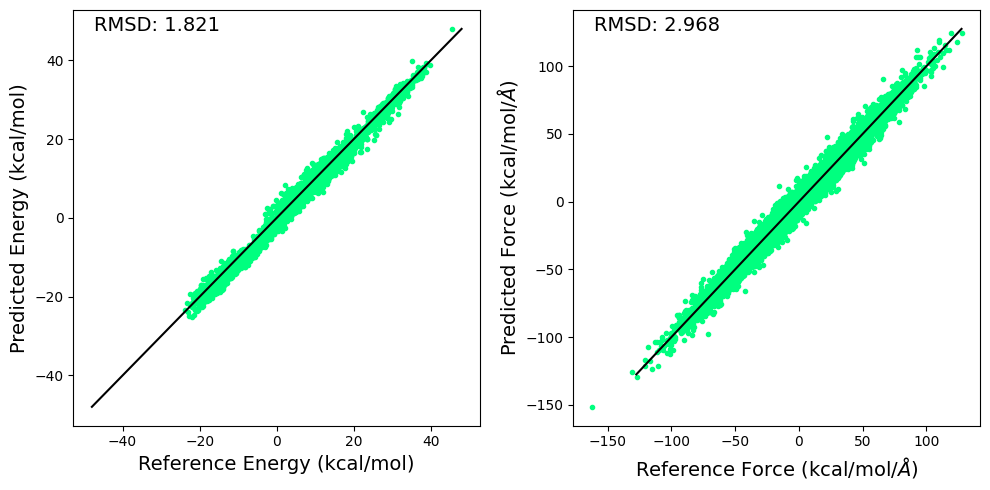

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
e2 = ene_pred.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061

ax[0].plot(e1, e2, linestyle='none', marker='.', color='springgreen')
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_pred.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', color='springgreen')
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel(r'Reference Force (kcal/mol/$\AA$)', size=14)
ax[1].set_ylabel(r'Predicted Force (kcal/mol/$\AA$)', size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

### The Model Weights and Biases Dictionary

This cell prints the size of the weights and biases used in the trained model for reference.

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fitting_net.fitting_net.0.weight 	 torch.Size([3, 240, 48])
fitting_net.fitting_net.0.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.1.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.1.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.2.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.2.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.3.weight 	 torch.Size([3, 1, 240])
fitting_net.fitting_net.3.bias 	 torch.Size([3, 1])


### Plotting Validation Error for $\Delta$MLP

Validation error for the $\Delta$MLP is shown below.

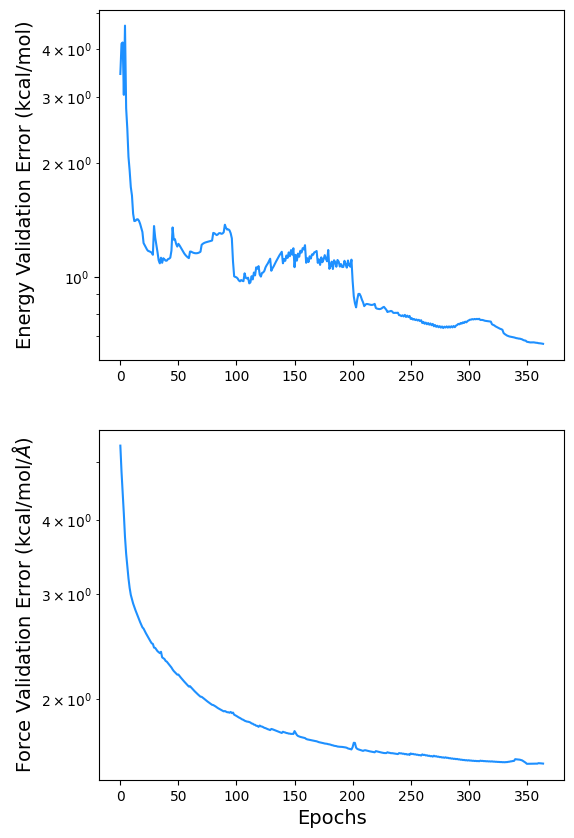

In [ ]:
import pandas as pd

data = pd.read_csv('logs_csv/lightning_logs/version_0/metrics.csv')
fig, ax = plt.subplots(2, figsize=(6,10))
x = data['epoch'][~data['l2_e_tst'].isnull()]
y = data['l2_e_tst'][~data['l2_e_tst'].isnull()]
y2 = data['l2_f_tst'][~data['l2_f_tst'].isnull()]
ax[0].semilogy(x, y,color='dodgerblue')
ax[0].set_ylabel('Energy Validation Error (kcal/mol)',size=14)
ax[1].semilogy(x, y2, label='Force Validation Error (kcal/mol',color='dodgerblue')
ax[1].set_xlabel('Epochs',size=14)
ax[1].set_ylabel(r'Force Validation Error (kcal/mol/$\AA$)',size=14)
fig.savefig('loss.png', dpi=300)

### Plotting Training and Validation Loss for $\Delta$MLP

The loss at each step of the training process is displayed below.

1152
365


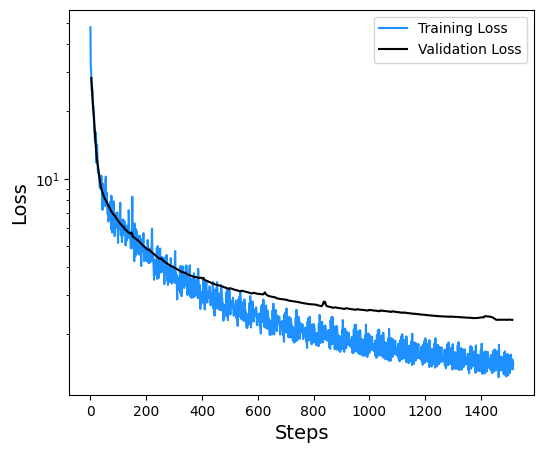

In [ ]:
data = pd.read_csv('logs_csv/lightning_logs/version_0/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Training Loss',color='dodgerblue')
y = data['val_loss'][~data['val_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Validation Loss',color='k')
plt.xlabel('Steps',size=14)
plt.ylabel('Loss',size=14)
plt.legend()